In [1]:
import torch

# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--2023-05-12 18:44:12--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-05-12 18:44:12 (21.6 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# Now that we have an encoder, we can encode the entire dataset:
data = torch.tensor(encode(text), dtype=torch.long, device=device)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


Next we can split our dataset into training and validation datasets:


In [7]:
spl = int(0.9 * len(data))

train_data = data[:spl]

val_data = data[spl:]

Our input data will contain mini-batches of blocks on tokens with block size <= block_size:

In [8]:
torch.manual_seed(1337)

batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')

print('inputs:')
print(xb.shape)
print(xb)
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'when input is {context.tolist()} the target: {target}')

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 

Now that we have our input/label generation sorted, we can start training a model. We can start with the BigramLanguageModel we've implemented in previous lectures as a baseline. We simply look up a probabilitiy distribution in the token embedding table and use that to predict the next character.

In [9]:
import torch.nn as nn
from torch.nn import functional as F

class BigramLangugageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # batch, timestep, channel

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLangugageModel(vocab_size).to(device)
out, loss = m(xb, yb)
print('loss:', loss)
print(out.shape)
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: tensor(5.0364, grad_fn=<NllLossBackward0>)
torch.Size([32, 65])

lfJeukRuaRJKXAYtXzfJ:HEPiu--sDioi;ILCo3pHNTmDwJsfheKRxZCFs
lZJ XQc?:s:HEzEnXalEPklcPU cL'DpdLCafBheH


In previous lectures we've implemented our own simple SGD optimizer -- this time we can just use one of PyTorch's built-in optimizers:

In [10]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

We can use the optimizer to train the Bigram model over a few steps:

In [11]:
import matplotlib.pyplot as plt
batch_size = 32
losses = []
for steps in range(50000):
    xb, yb = get_batch('train')

    logits, loss = m(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

KeyboardInterrupt: 

We are able to bring loss down from its initial value, but the model fails to improve much past ~2.5.

We can also try generating some tokens with our model, as you can see its still mostly giberish, but is closer to shakespearian engish than truly random characters would be (there are a few recognizable words, and words take on typical word lengths with punctuations interspersed)

In [ ]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=300)[0].tolist()))


hel, th aryooweaildernece lacarr pa quckicetispe he ang tse! e of IUSThe ict: y ave buthestor then his BY: ads, br y, g d treavechathaght aw paved, hemyo med 'd INGoo, ud morme sealdosiersprenasthasticallous ar ft;
Thele spad morspoulincous focomyor:
Hann bug f om r hertot suarngof heranoourd
V:
Tha


Next, we can implement a slightly more sophisticated model:
* we initialize a token and positional embedding table -- in addition to building embeddings for each token we also create embeddings for each relative position 
* we can then combine these embeddings into a single embedding using addition
* we can also specify the size of these embeddings, and then use a linear layer to downsample back to the desired output size (vocab size)


Note: Andrej really likes using global variables everywhere -- this gets too crazy for my liking!

In [ ]:
class CoolerBigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size, context_length) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, emb_size)
        self.positional_embedding_table = nn.Embedding(context_length, emb_size)
        self.output_layer = nn.Linear(emb_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # get token embeddings from input indices
        token_embeddings = self.token_embedding_table(idx)

        # get positional embeddings for each timestep
        B, T, C = token_embeddings.shape
        positional_embeddings = self.positional_embedding_table(torch.arange(T, device=idx.device))

        # add them together
        embeddings = token_embeddings + positional_embeddings   

        # pass thru linear layer
        logits = self.output_layer(embeddings)

        # everything else is the same as before
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    # same as before
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
        

In [ ]:
cooler_model = CoolerBigramLanguageModel(vocab_size, emb_size=32, max_tokens=block_size).to(device)
cooler_model(xb, yb)

(tensor([[-1.2781, -0.5503,  0.6041,  ...,  0.0863,  0.9100,  0.5680],
         [ 0.0649, -0.5802,  0.6924,  ..., -0.4131, -0.3060, -0.2062],
         [ 1.1192,  0.2993,  1.2210,  ..., -0.2418,  0.5849, -0.9333],
         ...,
         [ 0.4127,  0.0829, -0.0154,  ..., -0.6753, -0.5696,  1.1217],
         [-0.4504, -0.6388,  0.0993,  ..., -0.7462,  1.0912,  0.7653],
         [-0.3131, -0.7477,  0.7994,  ...,  0.3764,  0.2754, -0.7032]],
        grad_fn=<ViewBackward0>),
 tensor(4.4701, grad_fn=<NllLossBackward0>))

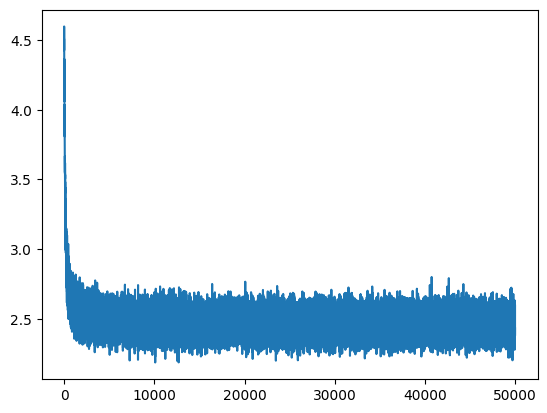

In [ ]:
optimizer = torch.optim.AdamW(cooler_model.parameters(), lr=1e-3)
batch_size = 32
losses = []
for steps in range(50000):
    xb, yb = get_batch('train')

    logits, loss = cooler_model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

Next, we can implement a self-attention head, then create a model that propogates through a self-attention head prior to the output layer.

In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, input_channels, output_channels, context_length) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        self.value = nn.Linear(input_channels, output_channels, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))
        
    def forward(self, idx):
        B, T, C = idx.shape
        
        # lookup query, key, and value vectors
        # C == input_channels, H == output_channels == head_size
        k = self.key(idx) # (B, T, C) -> (B, T, H)
        q = self.query(idx) # (B, T, C) -> (B, T, H)
        v = self.value(idx) # (B, T, C) -> (B, T, H)

        # compute self attention by taking dot product of query and key
        wei = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) -> (B, T, T)

        wei *= self.output_channels ** -0.5 # scale by sqrt of head size
        
        # apply lower triangular mask to weights
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B, T, T)

        # apply softmax to get attention weights
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # apply attention weights to values
        out = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)

        return out # (B, T, H)
    
    
class SingleHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length) -> None:
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_head = SelfAttentionHead(emb_size, head_size, context_length)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_head(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


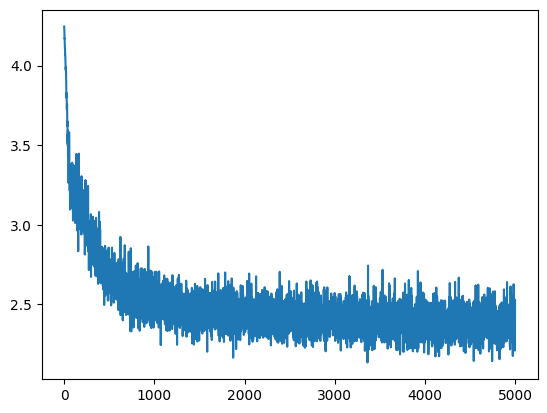

In [ ]:
single_head_model = SingleHeadModel(vocab_size, emb_size=32, head_size=32, context_length=block_size).to(device)
optimizer = torch.optim.AdamW(single_head_model.parameters(), lr=1e-3)

batch_size = 32
losses = []
for steps in range(5000):
    xb, yb = get_batch('train')

    logits, loss = single_head_model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

Next, instead of using a single attention head, we can try implementing Multi-Head Attention, which concatenates the results of multiple attention heads running in parallel.

The below implementation is not really parallel, but this is a task left for the exercises (I implement it in parallel there).

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, context_length, head_size, num_heads) -> None:
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttentionHead(emb_size, head_size, context_length) for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    

class MultiHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

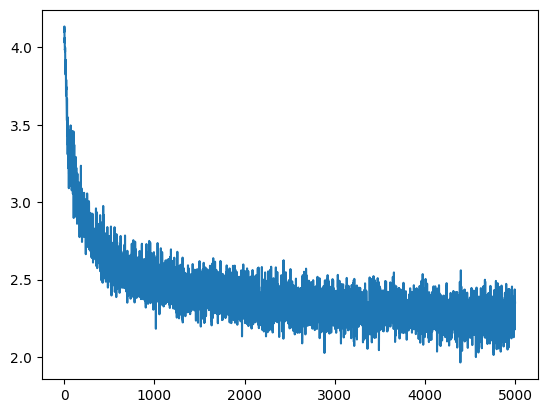

In [ ]:
multi_head_model = MultiHeadModel(vocab_size, emb_size=32, head_size=32, context_length=block_size, num_multi_attn_heads=4).to(device)
optimizer = torch.optim.AdamW(multi_head_model.parameters(), lr=1e-3)

batch_size = 32
losses = []
for steps in range(5000):
    xb, yb = get_batch('train')

    logits, loss = multi_head_model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        self.ff = nn.Sequential(
            nn.Linear(input_channels, output_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.ff(x)
    

class MultiHeadwFFModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads,) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

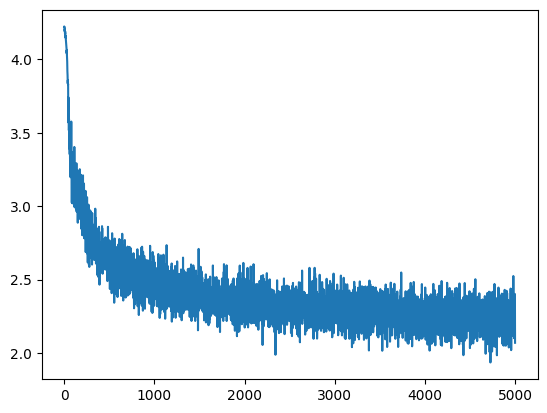

In [ ]:
multi_head_wff_model = MultiHeadwFFModel(vocab_size, emb_size=32, head_size=32, context_length=block_size, num_multi_attn_heads=4).to(device)
optimizer = torch.optim.AdamW(multi_head_wff_model.parameters(), lr=1e-3)

batch_size = 32
losses = []
for steps in range(5000):
    xb, yb = get_batch('train')

    logits, loss = multi_head_wff_model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

In [ ]:
class ResidualTransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, head_size, context_length, num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x # residual
        
        x = self.ff(self.norm2(x)) + x # residual
        
        return x
    

class MultiBlockModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[ResidualTransformerBlock(emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


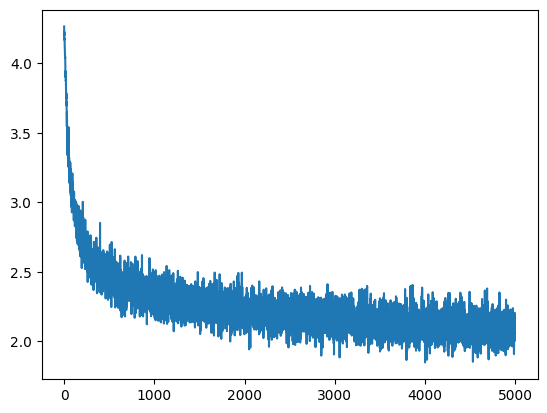

In [ ]:
multi_block_model = MultiBlockModel(vocab_size, emb_size=32, head_size=32, context_length=block_size, num_multi_attn_heads=4, num_blocks=4).to(device)
optimizer = torch.optim.AdamW(multi_block_model.parameters(), lr=1e-3)

batch_size = 32
losses = []
for steps in range(5000):
    xb, yb = get_batch('train')

    logits, loss = multi_block_model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

blocks include:

attention heads (contain query, key, value parameters) *these are poorly named
 -> intake B, T, n_emb, output B, T, n_emb

we concat many of these attention heads together, interspersed with residual connections
usually followed by a final MLP or linear block

